In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import signal
from rich.pretty import pprint
import mne
from sklearn.preprocessing import MinMaxScaler
from torcheeg.datasets import DREAMERDataset
from torcheeg.datasets.constants.emotion_recognition.dreamer import DREAMER_CHANNEL_LOCATION_DICT
from torcheeg import transforms
from torcheeg.utils import plot_signal

In [2]:
dataset_path = "./DREAMER.mat"
base_path = "./"

In [3]:
DREAMER_CHANNEL_LIST = list(DREAMER_CHANNEL_LOCATION_DICT.keys())

data_info = mne.create_info(
    ch_names=DREAMER_CHANNEL_LIST,
    sfreq=128,
    ch_types= "eeg",
    )

In [4]:
dataset = DREAMERDataset(
    # io_path=base_path + 'dreamer8sec',
    io_path=base_path + 'dreamer61sec_unnormalized',
    mat_path=dataset_path,
    offline_transform=transforms.Compose([
        transforms.BaselineRemoval(),
        # transforms.MeanStdNormalize(),
        transforms.To2d()
    ]),
    # online_transform=transforms.ToTensor(),
    label_transform=transforms.Compose(
        [transforms.Select('valence'),
         transforms.Binary(3.0)]),
    chunk_size=7808,
    baseline_chunk_size=7808,
    num_baseline=1
)

The target folder already exists, if you need to regenerate the database IO, please delete the path ./dreamer61sec_unnormalized.


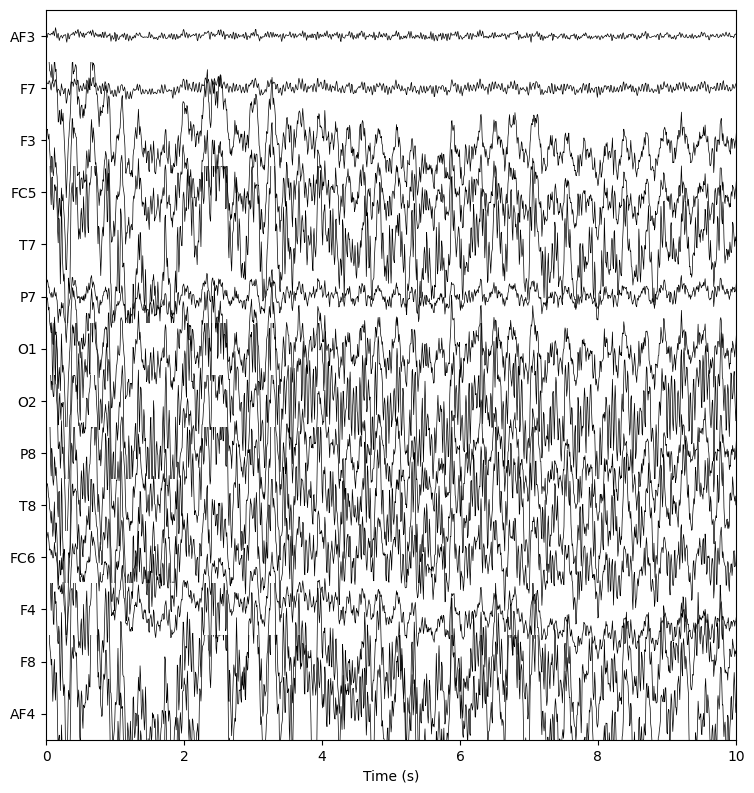

In [5]:
toTensor = transforms.ToTensor()
data = toTensor(eeg=dataset[10][0][0])["eeg"]

img = plot_signal(data,
                  channel_list=DREAMER_CHANNEL_LIST,
                  sampling_rate=128)

In [6]:
%pylab inline

from matplotlib import cm # to get a matplotlib.colors.ListedColormap
from matplotlib import style
style.use('fivethirtyeight')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [22]:
print("Dataset Shape: ", dataset[0][0][0].shape)
eeg = dataset[2][0][0][4].squeeze() # 1st trial, 1st channel, 1st chunk

print("EEG Shape: ", eeg.shape)
sr = 128 # sampling rate
time = np.arange(eeg.size)/sr
print('Sampling rate = %d samples/sec'%sr)

Dataset Shape:  (14, 7808)
EEG Shape:  (7808,)
Sampling rate = 128 samples/sec


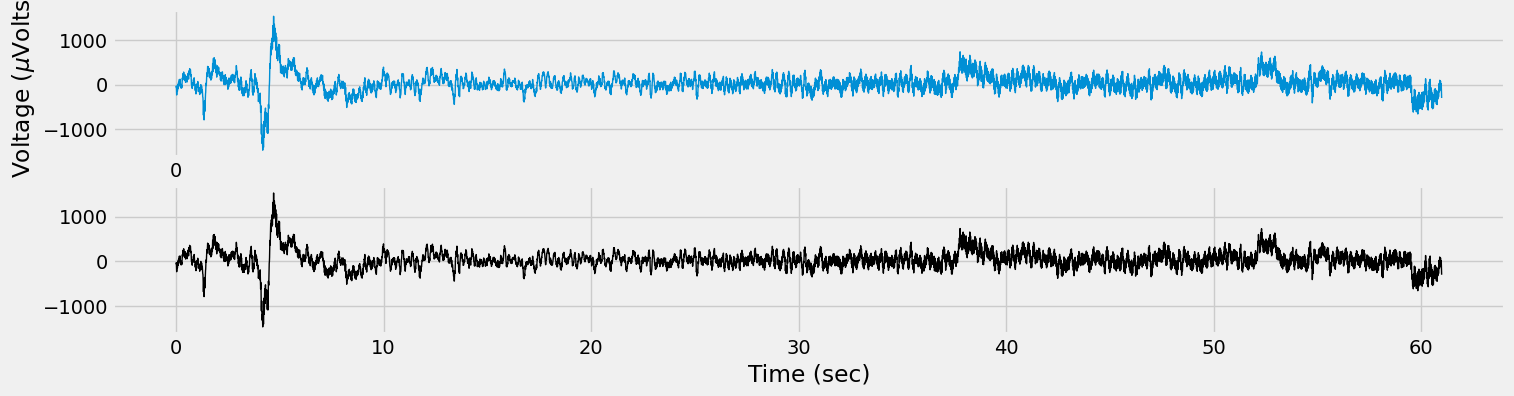

In [23]:
# plot the time course of the EEG
fig, ax = plt.subplots(2,1, figsize=(16,4), sharey=True)

ax[0].plot(time,eeg, lw=1)
ax[0].set_xlabel('Time (sec)'), ax[0].set_ylabel('Voltage ($\mu$Volts)');
ax[0].set_xticks(arange(0,8,60));

ax[1].plot(time, eeg, lw=1, color='k')
# ax[1].set_xlim(42.5,45)
#ax[1].set_xlim(12,14.5)
# ax[1].set_xticks(arange(43,45,1));
ax[1].set_xlabel('Time (sec)');

In [9]:
# Fourier transform
import math

FourierCoeff = np.fft.fft(eeg)/eeg.size
DC = [np.abs(FourierCoeff[0])]
amp = np.concatenate((DC, 2*np.abs(FourierCoeff[1:])))  

# compute frequencies vector until half the sampling rate
Nyquist = sr/2
print('Nyquist frequency = %2.4f Hz'%Nyquist)

Nsamples = int(math.floor(eeg.size/2) )
hz = np.linspace(0, Nyquist, num = Nsamples + 1 )
dhz = hz[1]
print('Spectral resolution = %2.4f Hz'%hz[1])

Nyquist frequency = 64.0000 Hz
Spectral resolution = 0.0164 Hz


In [10]:
# Perform Welch's periodogram
segment = int( 4*sr ) 
myhann = signal.get_window('hann', segment)

# obtain the power (uV^2) spectrum with Hann window and 50% overlap
myparams = dict(fs = sr, nperseg = segment, window = myhann, noverlap = segment/2, 
                scaling = 'spectrum', return_onesided = True)
freq, ps = signal.welch(x = eeg, **myparams)# units uV**2
ps = 2*ps

# obtain the power density/Hz (uV^2) spectrum with Hann window and 50% overlap
# to get back to simply power, divide by the segment lenght in seconds (four in our case)
myparams2 = dict(fs = sr, nperseg = segment, window = myhann, noverlap = segment/2, 
                 scaling = 'density', return_onesided = True)
freq, psd = signal.welch(x = eeg, **myparams2)# units uV**2/Hz
psd = 2*psd

dfreq = freq[1]
print('Spectral resolution = %2.4f Hz'%dfreq)

Spectral resolution = 0.2500 Hz


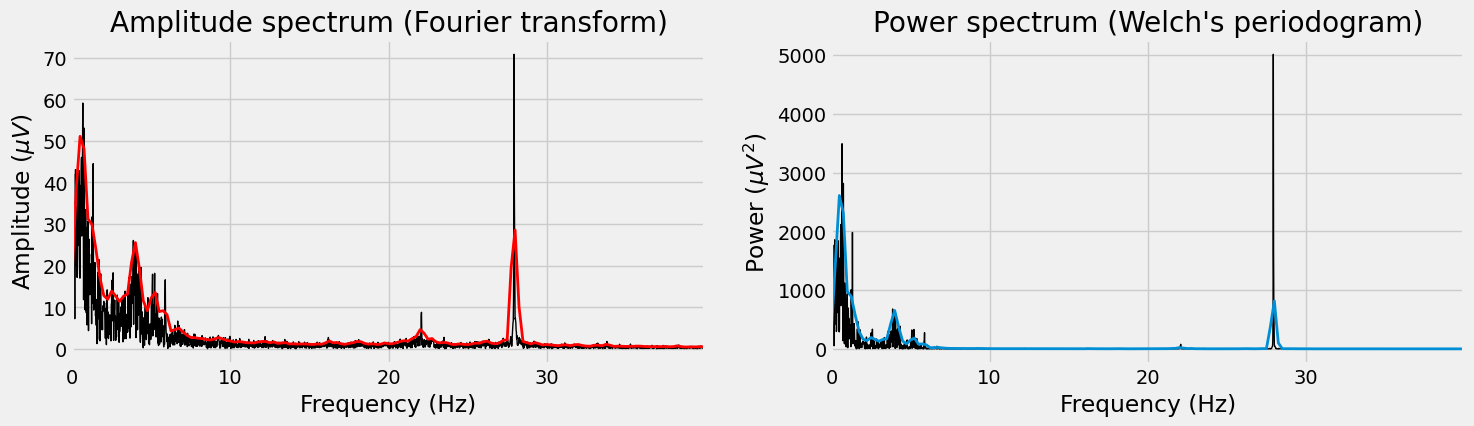

In [11]:
# Plot the power spectrum

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].set_title("Amplitude spectrum (Fourier transform)")
ax[0].plot(hz,amp[:len(hz)], lw=1, color='k')#, use_line_collection = True)
ax[0].plot(freq, np.sqrt(ps/10), color='red', lw=2) 
ax[0].set_ylabel('Amplitude ($\mu V$)')

ax[1].set_title("Power spectrum (Welch's periodogram)")
ax[1].plot(hz, np.power(amp[:len(hz)],2), color='k', lw =1)
ax[1].plot(freq, (ps/10), color='C0', lw=2)#, use_line_collection = True)
ax[1].set_ylabel('Power ($\mu V^2$)')

for myax in ax:
    myax.set_xlabel('Frequency (Hz)')
    myax.set_xlim(0,40)
    myticks = list(range(0,40,10))
    myax.set_xticks(myticks)
    # myax.set_ylim(ymax=1)

In [12]:
# compute the signal at 10 Hz
print('Signal amplitude @10 Hz     = %2.4f uVolts'%amp[int(10/dhz)]) 
print('Signal power @10 Hz         = %2.4f uVolts^2'%ps[int(10/dfreq)])
print('Singal power density @10 Hz = %2.4f uVolts^2/Hz'%psd[int(10/dfreq)])

Signal amplitude @10 Hz     = 0.6094 uVolts
Signal power @10 Hz         = 36.1138 uVolts^2
Singal power density @10 Hz = 96.3034 uVolts^2/Hz


In [13]:
# now we will analyze window lenghts of 500 ms in 25 ms steps. 
# Signals will overlap 475 ms
WinLength = int(0.5*sr) # 500 points (0.5 sec, 500 ms)
step = int(0.025*sr) # 25 points (or 25 ms)

# we have less resolution here because the signals are smaller
Nsamples = int( np.floor(WinLength/2) )
hz = np.linspace(0,Nyquist, Nsamples + 1)
dfreq = hz[1]
print('Spectral resolution = %2.4f Hz'%dfreq)

Spectral resolution = 2.0000 Hz


In [14]:
nsteps = int(np.floor ( (eeg.size - WinLength)/step) )
print(eeg.size, nsteps)

7808 2581


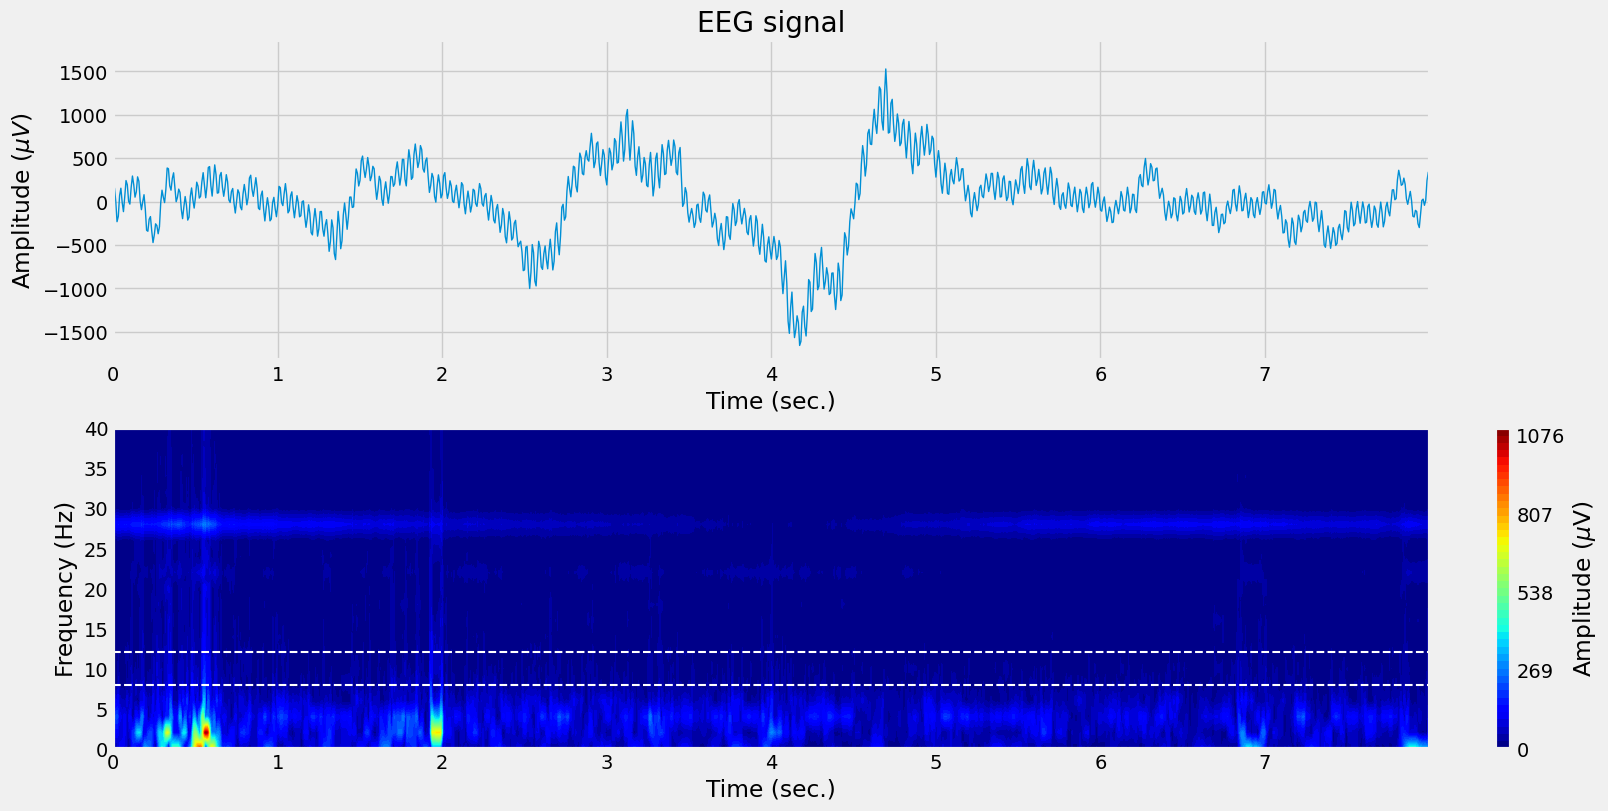

In [15]:
myamp = list()
for i in range(nsteps):
    
    # signal duration 500 ms (512 data points)
    data = eeg[i*step:i*step+WinLength]
    
    FourierCoeff = np.fft.fft(data)/WinLength
    DC = [np.abs(FourierCoeff[0])] # DC component
    amp = np.concatenate((DC, 2*np.abs(FourierCoeff[1:])))
    
    amp = amp[:int(45/dfreq)]
    myamp.append( amp )

power = np.power(myamp, 2)
#logpower = 10*np.log10(power)
fig, ax = plt.subplots(2,1, figsize = (16,8), constrained_layout=True)
#fig.suptitle('Time-frequency power via short-time FFT')

ax[0].plot(time, eeg, lw = 1, color='C0')
ax[0].set_ylabel('Amplitude ($\mu V$)')
ax[0].set_title('EEG signal')

# spectrum is a ContourSet object
dt = 8/nsteps # 120 seconds in number of steps
X = np.arange(nsteps)*dt
Y = hz[:int(45/dfreq)]
Z = np.array(myamp).T
levels = 45
spectrum = ax[1].contourf(X,Y,Z,levels, cmap='jet')#,'linecolor','none')

# get the colormap
cbar = plt.colorbar(spectrum)#, boundaries=np.linspace(0,1,5))
cbar.ax.set_ylabel('Amplitude ($\mu$V)', rotation=90)
cbar.set_ticks(np.arange(0,50,10))

#A working example (for any value range) with five ticks along the bar is:

m0=int(np.floor(np.min(myamp)))            # colorbar min value
m4=int(np.ceil(np.max(myamp)))             # colorbar max value
m1=int(1*(m4-m0)/4.0 + m0)               # colorbar mid value 1
m2=int(2*(m4-m0)/4.0 + m0)               # colorbar mid value 2
m3=int(3*(m4-m0)/4.0 + m0)               # colorbar mid value 3
cbar.set_ticks([m0,m1,m2,m3,m4])
cbar.set_ticklabels([m0,m1,m2,m3,m4])

#cbar.set_ticks(np.arange(0, 1.1, 0.5))

ax[1].axhline(y = 8, linestyle='--', linewidth = 1.5, color='white')
ax[1].axhline(y = 12, linestyle='--', linewidth = 1.5, color='white')
ax[1].set_ylim([0,40])
ax[1].set_yticks(arange(0,45,5))
ax[1].set_ylabel('Frequency (Hz)')


for myax in ax:
    myax.set_xlim(0, 8)
    myax.set_xticks(np.arange(0, 8, 1))
    myax.set_xlabel('Time (sec.)')

In [16]:
signal.spectrogram?

Signature:
signal.spectrogram(
    x,
    fs=1.0,
    window=('tukey', 0.25),
    nperseg=None,
    noverlap=None,
    nfft=None,
    detrend='constant',
    return_onesided=True,
    scaling='density',
    axis=-1,
    mode='psd',
)
Docstring:
Compute a spectrogram with consecutive Fourier transforms.

Spectrograms can be used as a way of visualizing the change of a
nonstationary signal's frequency content over time.

Parameters
----------
x : array_like
    Time series of measurement values
fs : float, optional
    Sampling frequency of the `x` time series. Defaults to 1.0.
window : str or tuple or array_like, optional
    Desired window to use. If `window` is a string or tuple, it is
    passed to `get_window` to generate the window values, which are
    DFT-even by default. See `get_window` for a list of windows and
    required parameters. If `window` is array_like it will be used
    directly as the window and its length must be nperseg.
    Defaults to a Tukey window with shape 

In [17]:
myparams = dict(nperseg = WinLength, noverlap = WinLength-step, return_onesided=True, mode='magnitude')
f, nseg, Sxx = signal.spectrogram(x = eeg, fs = sr, **myparams)

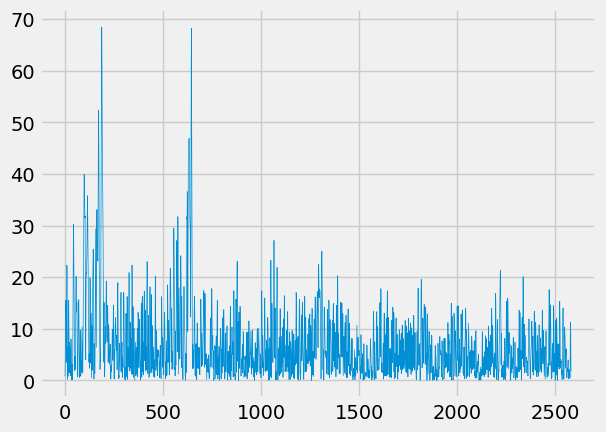

In [18]:
plt.plot(Sxx[0], lw =0.5)

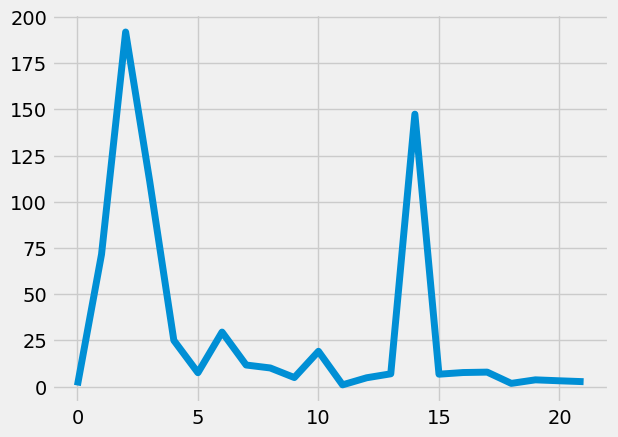

In [19]:
plt.plot(myamp[0], lw=5)

In [20]:
f[1]

2.0

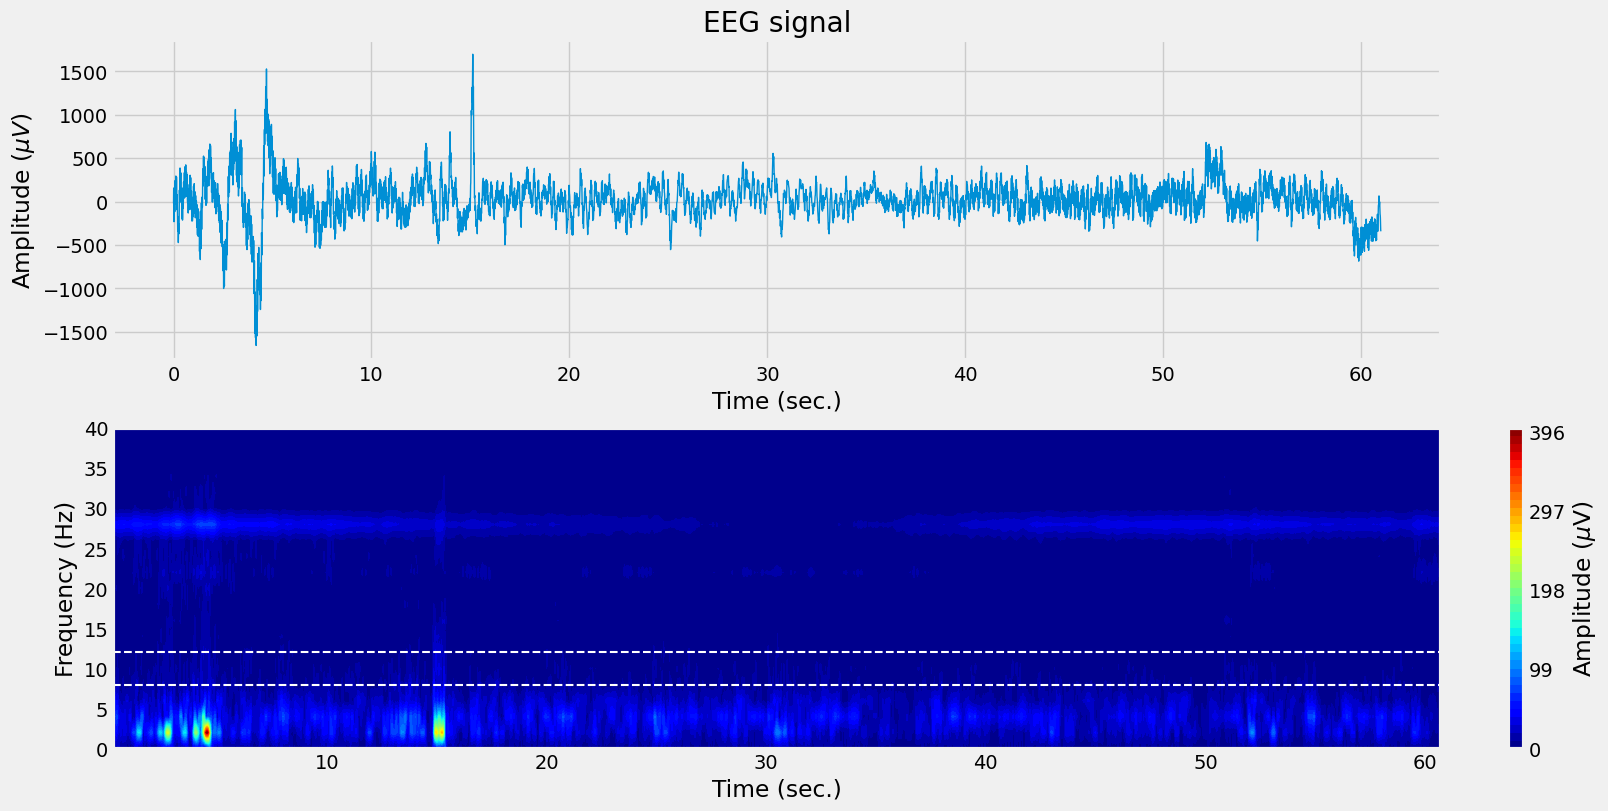

In [21]:
fig, ax = plt.subplots(2,1, figsize = (16,8), constrained_layout=True)

ax[0].plot(time, eeg, lw = 1, color='C0')
ax[0].set_ylabel('Amplitude ($\mu V$)')
ax[0].set_title('EEG signal')

# spectrum is a ContourSet object
dt = 8/nsteps # 120 seconds in number of steps
X = nseg
Y = f
Z = Sxx
levels = 45
spectrum = ax[1].contourf(X,Y,Z,levels, cmap='jet')#,'linecolor','none')

# get the colormap
cbar = plt.colorbar(spectrum)#, boundaries=np.linspace(0,1,5))
cbar.ax.set_ylabel('Amplitude ($\mu$V)', rotation=90)
cbar.set_ticks(np.arange(0,50,10))

#A working example (for any value range) with five ticks along the bar is:

m0=int(np.floor(np.min(Sxx)))            # colorbar min value
m4=int(np.ceil(np.max(Sxx)))             # colorbar max value
m1=int(1*(m4-m0)/4.0 + m0)               # colorbar mid value 1
m2=int(2*(m4-m0)/4.0 + m0)               # colorbar mid value 2
m3=int(3*(m4-m0)/4.0 + m0)               # colorbar mid value 3
cbar.set_ticks([m0,m1,m2,m3,m4])
cbar.set_ticklabels([m0,m1,m2,m3,m4])

#cbar.set_ticks(np.arange(0, 1.1, 0.5))

ax[1].axhline(y = 8, linestyle='--', linewidth = 1.5, color='white')
ax[1].axhline(y = 12, linestyle='--', linewidth = 1.5, color='white')
ax[1].set_ylim([0,40])
ax[1].set_yticks(arange(0,45,5))
ax[1].set_ylabel('Frequency (Hz)')


for myax in ax:
    #myax.set_xlim(0, 120)
    #myax.set_xticks(np.arange(0, 121, 30))
    myax.set_xlabel('Time (sec.)')